In [10]:
# Setup: imports and flexible DATA_ROOT detection
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import ast
import dask.dataframe as dd


# Try several strategies to find the `data` folder:
# 1) Environment variable `DATATHON_DATA` or `DATA_DIR`
# 2) current working directory / 'data'
# 3) ascend parent directories searching for 'data' (up to max_up)
# 4) common workspace path under home: '~/Documentos/Datathon-FME/data'

def find_data_dir(start: Path = Path('.'), name: str = 'data', max_up: int = 6, extra_candidates=None) -> Path:
    # check env vars first
    env_path = os.environ.get('DATATHON_DATA') or os.environ.get('DATA_DIR')
    if env_path:
        p = Path(env_path)
        if p.exists():
            return p
    # check provided extra candidates
    if extra_candidates:
        for c in extra_candidates:
            pc = Path(c).expanduser()
            if pc.exists():
                return pc
    # check start/data
    p = start.resolve()
    candidate = p / name
    if candidate.exists():
        return candidate
    # ascend
    for _ in range(max_up):
        p = p.parent
        candidate = p / name
        if candidate.exists():
            return candidate
    # fallback common path
    fallback = Path.home() / 'Documentos' / 'Datathon-FME' / 'data'
    if fallback.exists():
        return fallback
    # give a helpful error
    raise FileNotFoundError(
        f"Could not find '{name}' directory from {start}.\n"
        "Tried env DATATHON_DATA/DATA_DIR, parent traversal, and '~/Documentos/Datathon-FME/data'.\n"
        "If your data folder is in a different location, set the environment variable DATATHON_DATA or DATA_DIR,\n"
        "or move the notebook to the project root where a 'data' directory exists."
    )

# Determine data root
try:
    DATA_ROOT = find_data_dir(Path.cwd(), extra_candidates=[Path.cwd() / 'data'])
except FileNotFoundError:
    # as last resort, try the repository data path used in the project
    possible = Path.home() / 'Documentos' / 'Datathon-FME' / 'data'
    if possible.exists():
        DATA_ROOT = possible
    else:
        # re-raise original with guidance
        raise

print('DATA_ROOT =', DATA_ROOT)


DATA_ROOT = /home/marcessi/Documentos/Datathon-FME/data


In [11]:
# Quick checks and dataset listing
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

train_path = DATA_ROOT / 'train' / 'train'
if not train_path.exists():
    raise FileNotFoundError(f'Train path not found: {train_path}')

# show a few partition directories and file count
partitions = sorted([p for p in train_path.iterdir() if p.name.startswith('datetime=')])
print('Found partitions (first 8):')
for p in partitions[:8]:
    print(' -', p)

parquet_count = sum(1 for _ in train_path.rglob('*.parquet'))
print('\nTotal parquet files in train:', parquet_count)


Found partitions (first 8):
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-00-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-01-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-02-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-03-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-04-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-05-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-06-00
 - /home/marcessi/Documentos/Datathon-FME/data/train/train/datetime=2025-10-01-07-00

Total parquet files in train: 144


In [12]:
# Read a sample of the train dataset using Dask (Dask is required)
import glob
parquet_files = sorted([str(p) for p in (train_path).rglob('*.parquet')])
print('Parquet files found:', len(parquet_files))
if len(parquet_files) == 0:
    raise FileNotFoundError(f'No parquet files found in train_path: {train_path}')

# Use Dask to read the parquet dataset lazily and collect a head for EDA
print('Reading train with Dask (lazy) — this will not load full dataset into memory')
ddf = dd.read_parquet(str(train_path))
print('Dask partitions:', getattr(ddf, 'npartitions', 'unknown'))
# get a reasonable sample (head) for EDA (compute=True returns pandas DataFrame)
df_sample = ddf.head(100000, compute=True)
print('Sample shape:', df_sample.shape)
# keep df_sample for downstream cells


Parquet files found: 144
Reading train with Dask (lazy) — this will not load full dataset into memory
Dask partitions: 144
Sample shape: (100000, 85)
Sample shape: (100000, 85)


count 100000
% zeros 0.96311
nonzero count 3689
mean 9.545802092647875 median 0.0 std 2262.0744076831334
percentiles:
 0.50     0.000000
0.75     0.000000
0.90     0.000000
0.99    16.292224
Name: iap_revenue_d7, dtype: float64


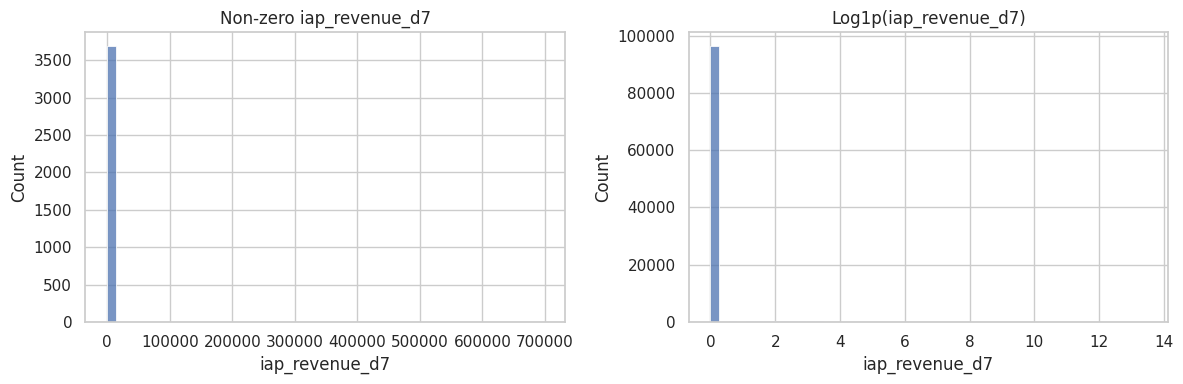


--- Top 20 advertiser_bundle ---


advertiser_bundle
7eaeef21e215654ea75a5ef78692d1f8ffd0ca54    22319
001b729f996da29d01e9e3641ac7fb153e6bc98e    11257
3435438fda9d548afbc383169b683389cae733f1     6045
ff9bdd5dc427114eef1c6372526548e01a5ef45d     3390
fcce26ae1abe348cb24c4f4e542957ef5d9773fd     2957
db42749ef73fd488a95e37718f033eab132da07c     2745
4dd4aa85cf8fae402f1dd15d2204226925b483e7     2662
3817dd799bec28bc68dcba7c6e6690a737af20cc     2458
3d42f06ec2d70fc6b15fc16552be5e5b6699d926     2353
962f78fdfc047d8067224649fdccf23c65e10280     2076
371932ceab23d320aba11487c09185578d38d767     1842
a53727ee495b346f5fb76a0dce8e88f22d26721b     1799
4129ba57f4f8d4da156bd7a3ba6bac99612b2d6d     1574
3b565d52f6463cc295dc9c1f82f9c2eb3aed0a38     1451
72e6c166e2a98b973fc396e756d88a900f36ece1     1440
444d1c9a32bc86a73ff0326956e2427380841533     1340
3714e810963165f514bbeec2cc0b54e91239314b     1327
08eedf6556269aca4241b42800d1096640eac506     1274
1c88d1e1f99e2e2c35b97272ecf52c9a9e0a905c     1211
7cf02571258cafc5210c214667eab510

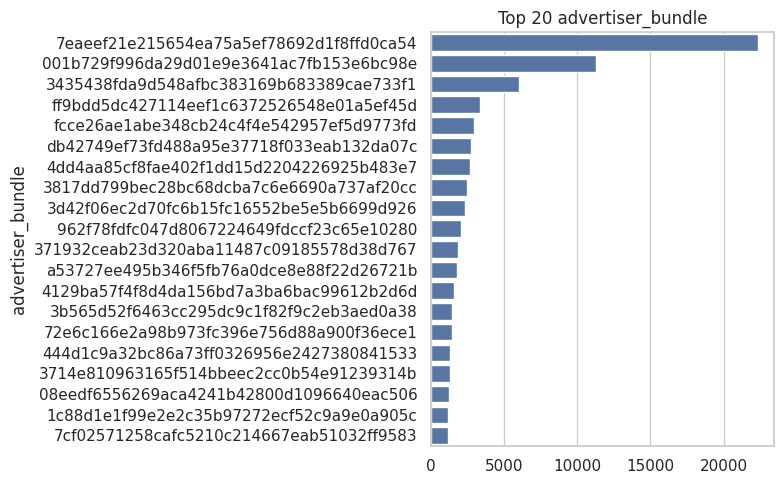


--- Top 20 country ---


country
us    23906
br     9338
in     5177
eg     5027
mx     4714
ar     3165
id     3085
ph     2583
co     2384
my     2282
ca     2076
th     1866
bd     1791
ru     1704
vn     1510
ci     1367
tr     1266
pk     1227
ng     1206
uz     1155
Name: count, dtype: int64

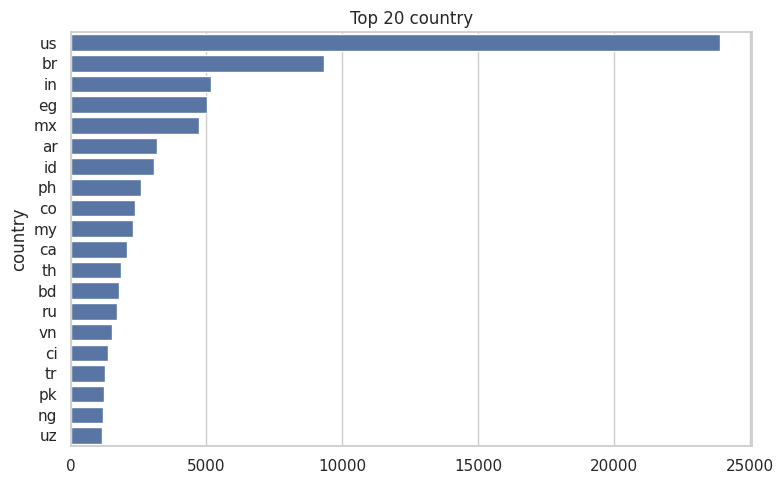


--- Top 20 dev_os ---


dev_os
android    80169
ios        19830
NULL           1
Name: count, dtype: int64

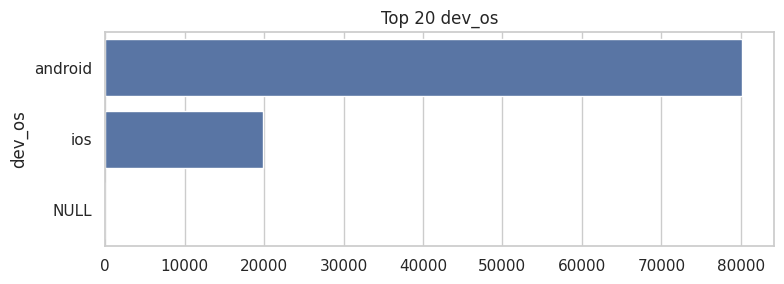


Top user_bundles (sample):


[('933549a417aedd5a59d0a42fa2ef15c6055a6302', 29),
 ('e407a7069edf3d1c7dcc230a85b44585cf2872bf', 20),
 ('86bb96570075ee974842788b62145443091f1814', 13),
 ('93d3de5c6eb6525790ac30975a3c36597534d5dd', 10),
 ('572f4ea557dbb90dad815064a616d7d7f76a939c', 7),
 ('bbe35f50788287728c18959fcda69d7bfec40cc7', 6),
 ('196a3140f7e12343a73f0877f304c29572a63355', 6),
 ('30d238735fa61f63d2c78a803e95d00b557b4553', 6),
 ('18fe18976bde5bed0cb1d1f9bb6cb9a7ae12bf13', 6),
 ('c7d2b81567354afa7b17d82485fec02063a4847c', 5),
 ('651aacdd3d46719aa49f5e6067a06f31df03ad47', 5),
 ('50d27130d9864e7e1078b533c957a10529899078', 5),
 ('65a8d3c240315103ee76259b5735fc41c8b01228', 4),
 ('679b34be71cfc957766f78f54e03c88dbc5d6692', 4),
 ('bd5c11a2e88363201096d0e69ffb4c5b43fc6a80', 4),
 ('029f92c816b93275060e7f8d0f5ed8a708a4aa75', 4),
 ('294ce7403c8f7c8ab417dc7a8d6e388cce24a639', 4),
 ('1ca3bb54716a1b36646ab2d7e4fa54ac7b913666', 3),
 ('7d8201075ae207f8da1c123c570c096357de0d8e', 3),
 ('32233e3b05ed51c8ee5deec8728fe79aa3686756', 

In [13]:
# Basic EDA: target distribution, top categories and basic plots
from IPython.display import display

target = 'iap_revenue_d7'
if target not in df_sample.columns:
    print(f'Column {target} not found in sample — available columns:')
    print(list(df_sample.columns)[:40])
else:
    ser = pd.to_numeric(df_sample[target], errors='coerce').fillna(0.0)
    n = len(ser)
    zeros = int((ser == 0.0).sum())
    nonzeros = n - zeros
    print('count', n)
    print('% zeros', zeros / n)
    print('nonzero count', nonzeros)
    print('mean', ser.mean(), 'median', ser.median(), 'std', ser.std())
    print('percentiles:\n', ser.quantile([0.5,0.75,0.9,0.99]))

    # Plots: non-zero histogram and log1p
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(ser[ser > 0], bins=50, ax=axes[0], kde=False)
    axes[0].set_title('Non-zero iap_revenue_d7')
    sns.histplot(np.log1p(ser), bins=50, ax=axes[1], kde=False)
    axes[1].set_title('Log1p(iap_revenue_d7)')
    plt.tight_layout()
    display(fig)
    plt.close(fig)

# Top categories examples
for col in ['advertiser_bundle', 'country', 'dev_os']:
    if col in df_sample.columns:
        vc = df_sample[col].fillna('NULL').astype(str).value_counts().head(20)
        print('\n--- Top 20', col, '---')
        display(vc)
        fig, ax = plt.subplots(figsize=(8, max(3, 0.25 * len(vc))))
        sns.barplot(x=vc.values, y=vc.index, ax=ax)
        ax.set_title(f'Top 20 {col}')
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Quick parsed example for a list-like column
def safe_parse(cell):
    try:
        return ast.literal_eval(cell) if pd.notna(cell) else []
    except Exception:
        return []

if 'user_bundles' in df_sample.columns:
    s = df_sample['user_bundles'].dropna().astype(str).head(2000)
    from collections import Counter
    c = Counter()
    for v in s:
        items = safe_parse(v)
        for it in items:
            if isinstance(it, (list, tuple)) and len(it) >= 1:
                key = it[0]
            else:
                key = it
            c[str(key)] += 1
    print('\nTop user_bundles (sample):')
    display(c.most_common(20))
